In [32]:
import matplotlib
import matplotlib.pyplot as plt

from datasets import get_dataset

import numpy as np
np.random.seed(123)

import random
random.seed(123)

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adadelta, SGD
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import label_binarize
import cv2
import pdb
import progressbar
import os
from scipy import stats
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [33]:
n_views = 5
dataset = 'australian'

In [34]:
# 1. Partition L into (v_1, v_2, ..., v_n)
def get_dset(dataset):
    ds = get_dataset(dataset, 0.7, 0.25)
    [L_x, L_y], U, [test_x, test_y] = ds.get_data()
    L_y = np.argmax(L_y, axis=1)
    test_y = np.argmax(test_y, axis=1)
    V = []
    for ind in range(n_views):
        left = int(ind * L_x.shape[0] / n_views)
        right = int((ind+1) * L_x.shape[0] / n_views)
        V.append([L_x[left:right], L_y[left:right]])
    return ds, [L_x, L_y], U, [test_x, test_y], V

In [35]:
# 2. Learn h_i on v_i using Learn
def get_classifiers(ds, L_x, L_y, U, test_x, test_y, V):
    H = []
    n_attr = V[0][0].shape[1]

    classifiers = [RandomForestClassifier(max_depth=2, random_state=0)
                   ,AdaBoostClassifier(),
                   GradientBoostingClassifier(),
                   KNeighborsClassifier()
                   ,MLPClassifier()]
    
    for ind in range(n_views):
        h = classifiers[ind]
        H.append(h)

    for ind in range(n_views):
        H[ind].fit(V[ind][0], V[ind][1])
        print accuracy_score(test_y, H[ind].predict(test_x))
    
    return H, n_attr

In [36]:
# 3
def cotrain(ds, L_x, L_y, U, test_x, test_y, V, H, n_attr):
    changed = True
    to_plot = []
    num_runs = 5
    while (changed and num_runs <= 10):
        print num_runs
        preds_L = []
        for ind in range(n_views):
            preds_L.append(H[ind].predict(L_x))
        preds_L = np.array(preds_L)
        # preds_L = np.argmax(preds_L, axis=2)

        preds_U = []
        for ind in range(n_views):
            preds_U.append(H[ind].predict(U))
        preds_U = np.array(preds_U)
        # preds_U = np.argmax(preds_U, axis=2)

        perfs = []
        test_preds = []
        for ind in range(n_views):
            test_preds.append(H[ind].predict(test_x))
        test_preds = np.array(test_preds)

        for ind in range(n_views):
            perf = accuracy_score(test_y, test_preds[ind])
            perfs.append(perf)
        perfs.append(accuracy_score(test_y,
                                    np.reshape(stats.mode(test_preds, axis=0)[0], (-1,))))
        to_plot.append(perfs)

        Q = []
        update = [False for _ in range(n_views)]
        for cur in range(n_views):
            elems_take = [view_ind for view_ind in range(n_views) if view_ind != cur]
            preds_others_L = preds_L[elems_take]
            preds_others_U = preds_U[elems_take]
            # pdb.set_trace()
            acc_others_L = accuracy_score(L_y, 
                                          np.reshape(stats.mode(preds_others_L, axis=0)[0], (-1,)))
            acc_cur_L = accuracy_score(L_y, preds_L[cur])
            q_cur = [[], []]
            if acc_others_L > acc_cur_L:
                update[cur] = True
                for u_ind in range(preds_U.shape[1]):
                    mode_prediction = stats.mode(preds_others_U[:, u_ind])[0][0]
                    if np.sum(preds_others_U[:, u_ind] == mode_prediction) >= 0.5 * (n_views - 1):
                        q_cur[0].append(U[u_ind])
                        label_temp = mode_prediction
                        q_cur[1].append(label_temp)
            Q.append([np.array(q_cur[0]), np.array(q_cur[1])])
        for cur in range(n_views):
            if update[cur]:
                comb_x = np.concatenate([L_x, Q[cur][0]], axis=0)
                comb_y = np.concatenate([L_y, Q[cur][1]], axis=0)
                H[cur].fit(comb_x, comb_y)

        preds_L_new = []
        for ind in range(n_views):
            preds_L_new.append(H[ind].predict(L_x))

        preds_U_new = []
        for ind in range(n_views):
            preds_U_new.append(H[ind].predict(U))

        # pdb.set_trace()
        same = np.array_equal(preds_L, np.array(preds_L_new)) and np.array_equal(preds_U, np.array(preds_U_new))
        changed = not same
        num_runs += 1
    return to_plot

In [37]:
def plot(to_plot, n_views, dset):
    plt.figure(figsize=(7, 7))
    plt.clf()
    handles = []
    labels = []
    for ind in range(n_views):
        ys = [x[ind] for x in to_plot]
        handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = str(ind))
        handles.append(handle)
        labels.append('Classifier %d' % ind)
    ys = [x[n_views] for x in to_plot]
    handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = 'Overall')
    handles.append(handle)
    labels.append('Max Voting')

    plt.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left")
    # plt.legend(handles, labels)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Iterations vs accuracy for Dataset: %s' % dset)
    plt.show()

0.637426900585
0.719298245614
0.678362573099
0.608187134503
0.491228070175
5
6
7
8
9
10


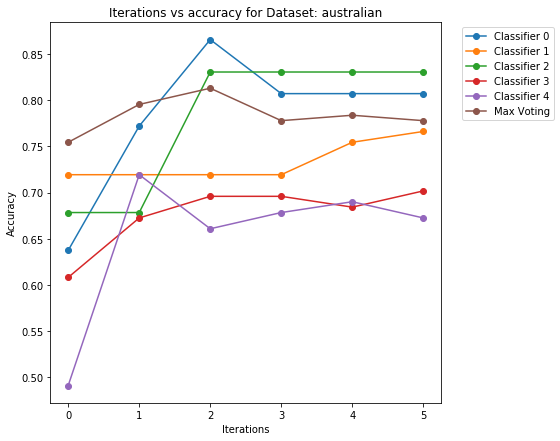

0.511627906977
0.546511627907
0.581395348837
0.558139534884
0.581395348837
5
6
7
8
9
10


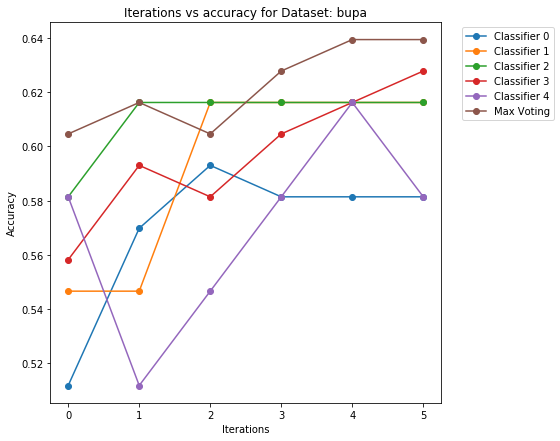

0.434782608696
0.630434782609
0.663043478261
0.695652173913
0.663043478261
5
6
7
8
9
10


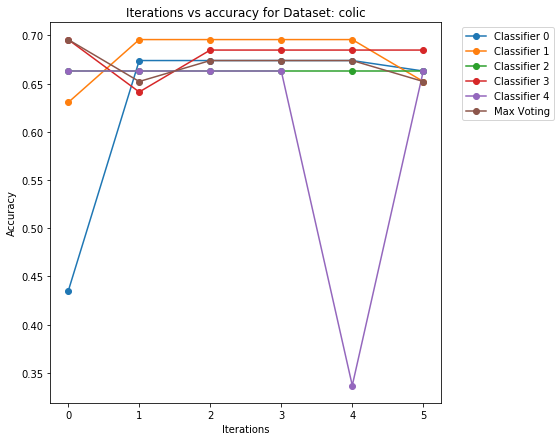

0.666666666667
0.666666666667
0.744791666667
0.6875
0.567708333333
5
6
7
8
9
10


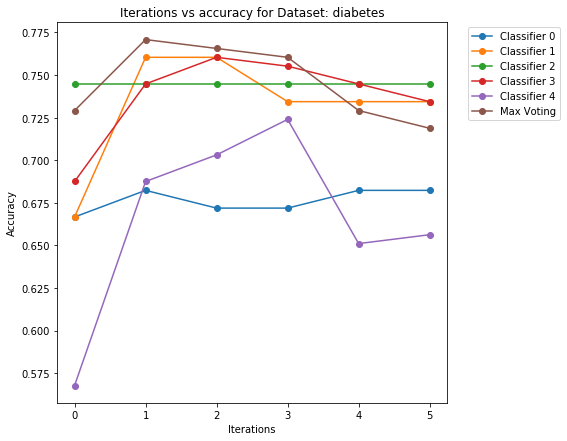

0.56
0.704
0.616
0.68
0.588
5
6


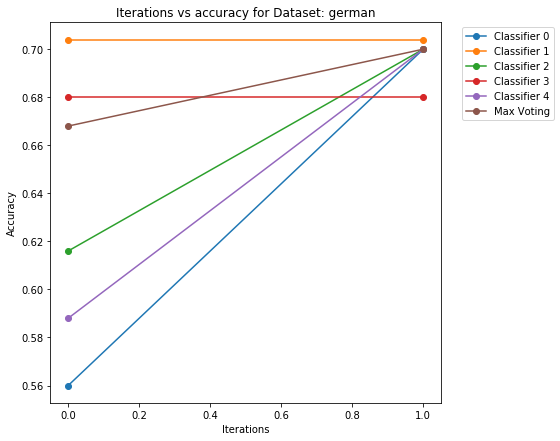

0.574712643678
0.655172413793
0.655172413793
0.64367816092
0.735632183908
5
6
7
8
9
10


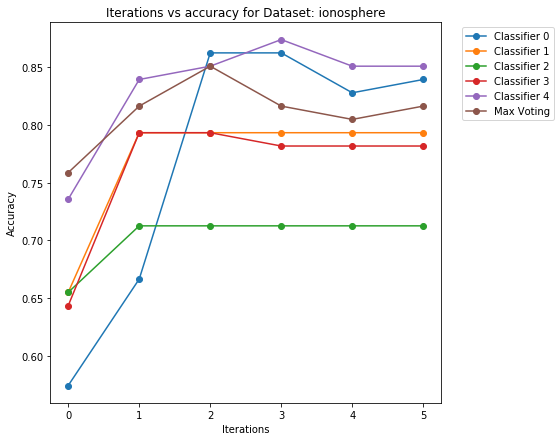

0.745614035088
0.889724310777
0.938596491228
0.779448621554
0.87343358396
5
6
7
8
9
10


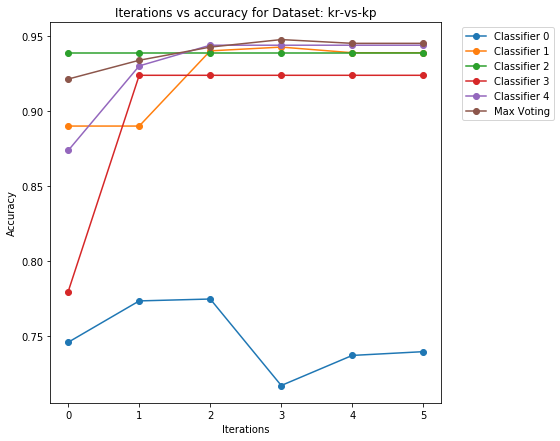

0.682008368201
0.719665271967
0.694560669456
0.719665271967
0.694560669456
5
6
7
8
9
10


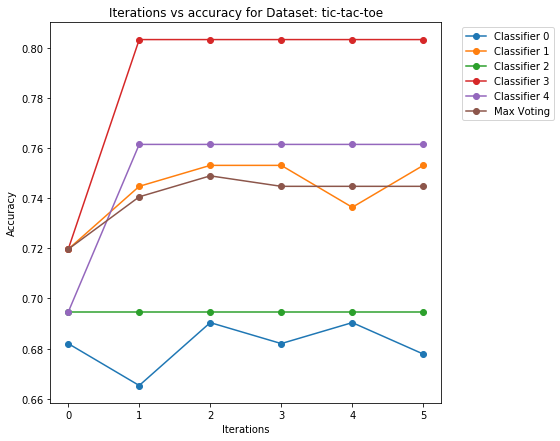

0.925925925926
0.962962962963
0.657407407407
0.87962962963
0.907407407407
5
6
7
8


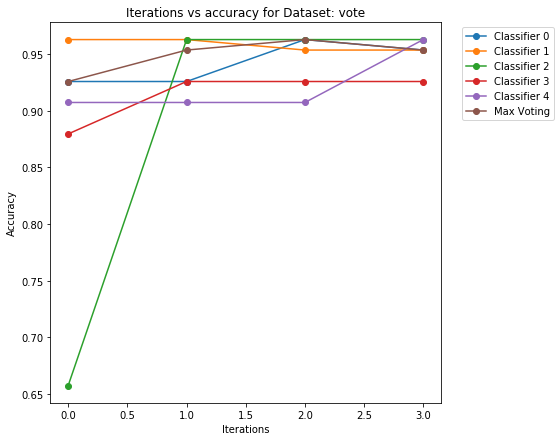

0.915492957746
0.922535211268
0.93661971831
0.584507042254
0.37323943662
5
6
7
8
9
10


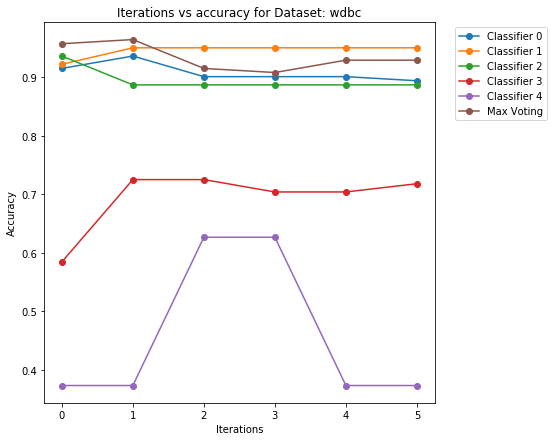

In [38]:
for dset in ['australian', 'bupa', 'colic', 'diabetes', 'german', 'ionosphere', 'kr-vs-kp', 'tic-tac-toe', 'vote', 'wdbc']:
    ds, [L_x, L_y], U, [test_x, test_y], V = get_dset(dset)
    H, n_attr = get_classifiers(ds, L_x, L_y, U, test_x, test_y, V)
    to_plot = cotrain(ds, L_x, L_y, U, test_x, test_y, V, H, n_attr)
    plot(to_plot, n_views, dset)